In [85]:
import gym
from gym import spaces
import numpy as np
import torch
import pandas as pd
import ta

In [86]:

def normalize_state(state):
    # Zakładamy, że state to wektor [features]
    mean = np.mean(state, axis=0)
    std = np.std(state, axis=0) + 1e-8
    return (state - mean) / std

class TimeSeriesEnvOHLC_ls(gym.Env):
    def __init__(self, data, window_size=96, verbose= False):
        super(TimeSeriesEnvOHLC_ls, self).__init__()
        self.window_size = window_size
        self.verbose = verbose
        self.df = data.copy()
        
        # Wskaźniki techniczne
        self.df['SMA'] = ta.trend.sma_indicator(self.df['close'], window=14)
        self.df['EMA'] = ta.trend.ema_indicator(self.df['close'], window=14)
        self.df['RSI'] = ta.momentum.rsi(self.df['close'], window=14)
        self.df['MACD'] = ta.trend.macd_diff(self.df['close'])
        self.df['BB_upper'] = ta.volatility.bollinger_hband(self.df['close'])
        self.df['BB_lower'] = ta.volatility.bollinger_lband(self.df['close'])
        median_price = (self.df['high'] + self.df['low']) / 2
        self.df['MOM'] = median_price.rolling(window=5).mean() - median_price.rolling(window=34).mean()
        self.df.fillna(0.0, inplace=True)
        
        self.ohlc_data = self.df[['open', 'high', 'low', 'close',
                                  'SMA', 'EMA', 'RSI', 'MACD',
                                  'BB_upper', 'BB_lower', 'MOM']].values
        
        self.current_step = window_size
        
        # Action space: 0=hold, 1=buy/long, 2=sell/short
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(
            low=0.0, high=1.0, 
            shape=(window_size, self.ohlc_data.shape[1]), 
            dtype=np.float32
        )
        
        self.min_val = np.min(self.ohlc_data, axis=0)
        self.max_val = np.max(self.ohlc_data, axis=0)
        
        self.initial_cash = 100_000.0
        self.cash = self.initial_cash
        self.long_inventory = []   # list of entry prices
        self.short_inventory = []  # list of entry prices
        self.total_profit = 0.0
        self.last_portfolio_value = self.initial_cash
        self.states_buy = []
        self.states_sell = []
    
    def reset(self):
        self.current_step = self.window_size
        self.cash = self.initial_cash
        self.long_inventory = []
        self.short_inventory = []
        self.total_profit = 0.0
        self.last_portfolio_value = self.initial_cash
        self.states_buy = []
        self.states_sell = []
        return self._get_observation()
    
    def _get_observation(self):
        window = self.ohlc_data[self.current_step - self.window_size:self.current_step]
        min_val = np.min(window, axis=0)
        max_val = np.max(window, axis=0)
        norm_window = normalize_state(window)
        #norm_window = (window - min_val) / (max_val - min_val + 1e-8)
        return np.clip(norm_window.astype(np.float32), -5, 5)
    
    def _portfolio_value(self, current_price):
        """Aktualna wartość portfela: gotówka + wartość pozycji."""
        return self.cash + self.position * (current_price - self.entry_price)

    def step(self, action):
        done = False
        price = self.ohlc_data[self.current_step][3]
        prev_price = self.ohlc_data[self.current_step - 1][3]

        action_name = ['HOLD', 'BUY', 'SELL'][action]

        # ==========================================
        # STORE STATE AT TIME t (BEFORE ACTION)
        # ==========================================
        balance_t = self.cash
        long_inventory_t = self.long_inventory.copy()
        short_inventory_t = self.short_inventory.copy()

        # Portfolio value at time t
        portfolio_value_t = self.cash
        for long_entry in self.long_inventory:
            portfolio_value_t += (prev_price - long_entry)
        for short_entry in self.short_inventory:
            portfolio_value_t += (short_entry - prev_price)

        # ==========================================
        # EXECUTE ACTION
        # ==========================================
        transaction_value = 0.0  # For calculating commission
        profit = 0.0
        if action == 1:  # BUY / LONG
            if len(self.short_inventory) > 0:
                # Close short position
                short_entry = self.short_inventory.pop(0)
                profit = short_entry - price
                self.cash += profit
                self.total_profit += profit
                transaction_value = price  # Transaction value for commission
            else:
                # Open long position
                self.long_inventory.append(price)
                self.states_buy.append(self.current_step)
                transaction_value = price

        elif action == 2:  # SELL / SHORT
            if len(self.long_inventory) > 0:
                # Close long position
                long_entry = self.long_inventory.pop(0)
                profit = price - long_entry
                self.cash += profit
                self.total_profit += profit
                transaction_value = price
            else:
                # Open short position
                self.short_inventory.append(price)
                self.states_sell.append(self.current_step)
                transaction_value = price

        # ==========================================
        # CALCULATE PORTFOLIO VALUE AT TIME t+1 (AFTER ACTION)
        # ==========================================
        portfolio_value_t1 = self.cash
        for long_entry in self.long_inventory:
            portfolio_value_t1 += (price - long_entry)
        for short_entry in self.short_inventory:
            portfolio_value_t1 += (short_entry - price)

        # ==========================================
        # CALCULATE REWARD (PAPER'S EQUATION 4)
        # ==========================================
        commission_rate = 0.001  # 0.1%
        transaction_cost = transaction_value * commission_rate

        # Reward = change in portfolio value - transaction cost
        #reward = portfolio_value_t1 - portfolio_value_t
        
        self.last_portfolio_value = portfolio_value_t1
        self.current_step += 1

        reward = np.clip(profit, -1, 1)


        #reward = portfolio_value_t1 - portfolio_value_t
        #reward = np.tanh(reward * 100)
        # ==========================================
        # DONE CONDITION
        # ==========================================
        if self.current_step >= len(self.ohlc_data):
            done = True
            final_price = self.ohlc_data[-1][3]

            # Close all positions
            for long_entry in self.long_inventory:
                profit = final_price - long_entry
                self.cash += profit
                self.total_profit += profit

            for short_entry in self.short_inventory:
                profit = short_entry - final_price
                self.cash += profit
                self.total_profit += profit

            if self.verbose:
                print(f"{'='*110}")
                print(f"DONE | Final Portfolio: {self.cash:12.2f} | "
                    f"Total P/L: {self.total_profit:+10.2f} | "
                    f"Total Trades: {len(self.states_buy) + len(self.states_sell)}")
                print(f"{'='*110}")

        # ==========================================
        # LOG
        # ==========================================
        if self.verbose and self.current_step % 222 == 0:
            print(f"Step: {self.current_step:4d} | Action: {action_name:4s} | "
                f"Price: {price:8.2f} | Reward: {reward:+8.6f} | "
                f"Longs: {len(self.long_inventory):2d} | Shorts: {len(self.short_inventory):2d} | "
                f"Portfolio Value: {portfolio_value_t1:12.2f}")

        return self._get_observation(), float(reward), done

In [87]:

def normalize_state(state):
    # Zakładamy, że state to wektor [features]
    mean = np.mean(state, axis=0)
    std = np.std(state, axis=0) + 1e-8
    return (state - mean) / std

class TimeSeriesEnvOHLC(gym.Env):
    def __init__(self, data, window_size=96, verbose= False):
        super(TimeSeriesEnvOHLC, self).__init__()
        self.window_size = window_size
        self.verbose = verbose
        self.df = data.copy()
        
        # Wskaźniki techniczne
        self.df['SMA'] = ta.trend.sma_indicator(self.df['close'], window=14)
        self.df['EMA'] = ta.trend.ema_indicator(self.df['close'], window=14)
        self.df['RSI'] = ta.momentum.rsi(self.df['close'], window=14)
        self.df['MACD'] = ta.trend.macd_diff(self.df['close'])
        self.df['BB_upper'] = ta.volatility.bollinger_hband(self.df['close'])
        self.df['BB_lower'] = ta.volatility.bollinger_lband(self.df['close'])
        median_price = (self.df['high'] + self.df['low']) / 2
        self.df['MOM'] = median_price.rolling(window=5).mean() - median_price.rolling(window=34).mean()
        self.df.fillna(0.0, inplace=True)
        
        self.ohlc_data = self.df[['open', 'high', 'low', 'close',
                                  'SMA', 'EMA', 'RSI', 'MACD',
                                  'BB_upper', 'BB_lower', 'MOM']].values
        
        self.current_step = window_size
        
        # Action space: 0=hold, 1=buy/long, 2=sell/short
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(
            low=0.0, high=1.0, 
            shape=(window_size, self.ohlc_data.shape[1]), 
            dtype=np.float32
        )
        
        self.min_val = np.min(self.ohlc_data, axis=0)
        self.max_val = np.max(self.ohlc_data, axis=0)
        
        self.initial_cash = 100_000.0
        self.cash = self.initial_cash
        self.inventory = []
        self.long_inventory = []   # list of entry prices
        self.short_inventory = []  # list of entry prices
        self.total_profit = 0.0
        self.last_portfolio_value = self.initial_cash
        self.states_buy = []
        self.states_sell = []
    
    def reset(self):
        self.current_step = self.window_size
        self.cash = self.initial_cash
        self.long_inventory = []
        self.short_inventory = []
        self.inventory = []
        self.total_profit = 0.0
        self.last_portfolio_value = self.initial_cash
        self.states_buy = []
        self.states_sell = []
        return self._get_observation()
    
    def _get_observation(self):
        window = self.ohlc_data[self.current_step - self.window_size:self.current_step]
        min_val = np.min(window, axis=0)
        max_val = np.max(window, axis=0)
        norm_window = normalize_state(window)
        #norm_window = (window - min_val) / (max_val - min_val + 1e-8)
        return np.clip(norm_window.astype(np.float32), -5, 5)
    
    def _portfolio_value(self, current_price):
        """Aktualna wartość portfela: gotówka + wartość pozycji."""
        return self.cash + self.position * (current_price - self.entry_price)

    def step(self, action):
        done = False
        price = self.ohlc_data[self.current_step][3]
        prev_price = self.ohlc_data[self.current_step - 1][3]

        action_name = ['HOLD', 'BUY', 'SELL'][action]

        # ==========================================
        # STORE STATE AT TIME t (BEFORE ACTION)
        # ==========================================
        balance_t = self.cash
        long_inventory_t = self.long_inventory.copy()
        short_inventory_t = self.short_inventory.copy()

        # Portfolio value at time t
        portfolio_value_t = self.cash
        for long_entry in self.long_inventory:
            portfolio_value_t += (prev_price - long_entry)
        for short_entry in self.short_inventory:
            portfolio_value_t += (short_entry - prev_price)

        # ==========================================
        # EXECUTE ACTION
        # ==========================================
        transaction_value = 0.0  # For calculating commission
        profit = 0.0

        reward = np.clip(profit, -1.0, 1.0)
        if action == 1:  # Buy
            self.inventory.append(price)
            self.states_buy.append(self.current_step)

        elif action == 2 and len(self.inventory) > 0:  # Sell
            bought_price = self.inventory.pop(0)
            profit = (price - bought_price) #/ bought_price 
            reward = np.clip(profit, -1, 1)
            self.total_profit += profit
            #reward = profit
            self.states_sell.append(self.current_step)

        self.current_step += 1

        if self.current_step >= len(self.ohlc_data):
            done = True
            if len(self.inventory) > 0:
                self.total_profit += np.sum(self.ohlc_data[-1][3] - np.array(self.inventory, dtype=np.float32))


        return self._get_observation(), float(reward), done

         open        high         low       close  volume
0  100.000000  100.407106   99.331123  100.000000     917
1  100.000000  101.319342   99.201344  101.253332     909
2  101.253332  102.835719  100.320579  102.486899     991
3  102.486899  103.792244  102.466761  103.681246     910
4  103.681246  105.625772  103.527462  104.817537     996


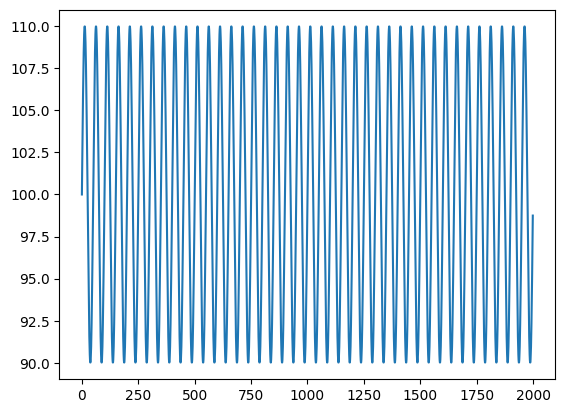

In [88]:
import numpy as np
import pandas as pd

def generate_sine_ohlc(n_steps=500, amplitude=10, base_price=100, noise_std=0.0, seed=42):
    np.random.seed(seed)
    t = np.arange(n_steps)
    
    # Close = sinus + szum
    close = base_price + amplitude * np.sin(2 * np.pi * t / 50) + np.random.normal(0, noise_std, n_steps)
    
    # Open = poprzednie close
    open_ = np.roll(close, 1)
    open_[0] = close[0]
    
    # High / Low = +/- losowy drobny zakres
    high = np.maximum(open_, close) + np.random.uniform(0, 1, n_steps)
    low = np.minimum(open_, close) - np.random.uniform(0, 1, n_steps)
    
    # Volume (opcjonalnie)
    volume = np.random.randint(900, 1000, n_steps)
    
    ohlc = pd.DataFrame({
        'open': open_,
        'high': high,
        'low': low,
        'close': close,
        'volume': volume
    })
    
    return ohlc

# Przykład
df = generate_sine_ohlc(n_steps=2000)
print(df.head())
import matplotlib.pyplot as plt
plt.plot(df['close'])


In [ ]:
from trade_rl.utils.database import read_stock_data

df = read_stock_data('NVDA')[0]
df = df[['open', 'high', 'low', 'close', 'volume']]

In [ ]:
from trade_rl.agents.rainbowDQN import RainbowAgent
from trade_rl.agent_env.enviroments import TimeSeriesEnv_simple


In [91]:
# Długość całego zbioru
n = len(df)

# Proporcje
train_end = int(0.8 * n)

# Podziały
train_df = df.iloc[:train_end]
valid_df = df.iloc[train_end:]

# env = TimeSeriesEnv_simple(train_df, 96)
# valid_env = TimeSeriesEnv_simple(valid_df, 96)
env = TimeSeriesEnvOHLC_ls(train_df, 256)
valid_env = TimeSeriesEnvOHLC_ls(valid_df, 256)

env.reset()

array([[-0.29494324, -0.3554704 , -1.1608952 , ..., -3.5187724 ,
        -3.511226  , -0.24938466],
       [-1.0693583 , -0.8121781 , -1.0339905 , ..., -3.5187724 ,
        -3.511226  , -0.24938466],
       [-0.7540608 , -0.78962463, -0.9961891 , ..., -3.5187724 ,
        -3.511226  , -0.24938466],
       ...,
       [ 0.45457995,  0.41980502,  0.48346552, ...,  0.37110743,
         0.3714039 , -0.9553521 ],
       [ 0.37437266,  0.28166506,  0.30525893, ...,  0.37080967,
         0.36188984, -1.0408231 ],
       [ 0.23608425,  0.1378867 ,  0.08925095, ...,  0.37113068,
         0.34802374, -1.1065857 ]], dtype=float32)

In [92]:
agent = RainbowAgent('sine')

In [93]:
def test_dqn_agent(env, agent, device="cuda:0", plot=True):
    """
    Testuje agenta DQN (lub Rainbow DQN) w środowisku OHLC
    i wizualizuje działania agenta.
    """
    state = env.reset()
    done = False
    total_reward = 0
    steps = 0

    # Wyzeruj stany kupna/sprzedaży
    env.states_buy = []
    env.states_sell = []

    while not done:
        # --- przygotowanie stanu ---
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

        # --- wybór akcji ---
        with torch.no_grad():
            q_values = agent.model(state_tensor)
            action = torch.argmax(q_values, dim=1).item()  # 0=hold,1=long,2=short

        # --- wykonanie kroku w środowisku ---
        next_state, reward, done = env.step(action)

        total_reward += reward
        steps += 1
        state = next_state

    prices = env.ohlc_data[:, 3]  # kolumna 'close'
    buy_points = [i for i in env.states_buy if i < len(prices)]
    sell_points = [i for i in env.states_sell if i < len(prices)]
    profit = env.total_profit

    if plot:
        print(f"Łączny reward: {profit:.2f} | Liczba kroków: {steps}")

        # --- wizualizacja ---
        plt.figure(figsize=(14, 6))
        plt.plot(prices, label='Cena', linewidth=1.5)

        if buy_points:
            plt.scatter(buy_points, [prices[i] for i in buy_points],
                        color='green', marker='^', label='Kup', s=100)
        if sell_points:
            plt.scatter(sell_points, [prices[i] for i in sell_points],
                        color='red', marker='v', label='Sprzedaj', s=100)

        plt.title(f'Działania agenta DQN | Łączny zysk: {profit:.2f}')
        plt.axvline(x=env.window_size, color='red', linestyle='--', label='Początek okna')
        plt.xlabel('Krok')
        plt.ylabel('Cena')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return profit


In [94]:
from tqdm import tqdm
import numpy as np
import torch

# Parametry treningu
num_episodes = 20
epsilon_start = 1.0
epsilon_end = 0.05
epsilon_decay = 0.995
epsilon_decay = (epsilon_start - epsilon_end) / num_episodes

agent.model.train()
episode_rewards = []

epsilon = epsilon_start
rewards = []
for episode in tqdm(range(num_episodes), desc="Training Rainbow DQN"):
    state = env.reset()
    done = False
    total_reward = 0
    step = 0

    while not done:
        step += 1
        
        # Eksploracja tylko jeśli nie używamy NoisyNets
        if np.random.random() < epsilon:
            action = np.random.randint(agent.action_space)
        else:
            action = agent.get_action(state)

        next_state, reward, done = env.step(action)
        total_reward += reward

        # Zapis doświadczenia
        agent.update_replay_memory((state, action, reward, next_state, done))
        state = next_state

        # Trening agenta
        agent.train()

    reward = test_dqn_agent(valid_env, agent, plot=False)
    print(f"Epizod {episode + 1}: Łączny reward: {reward:.2f}")
    # Zmniejszanie epsilon (jeśli nie używasz NoisyNet)
    epsilon = max(epsilon_end, epsilon - epsilon_decay)
    rewards.append(reward)
    episode_rewards.append(total_reward)

    # Ewaluacja co pewien czas
    if (episode + 1) % 10 == 0:
        avg_reward = np.mean(episode_rewards[-10:])
        print(f"Epizod {episode + 1} | Śr. nagroda: {avg_reward:.2f} | Epsilon: {epsilon:.3f}")
        agent.save()


Training Rainbow DQN:   5%|▌         | 1/20 [00:21<06:49, 21.54s/it]

Epizod 1: Łączny reward: -296.74


Training Rainbow DQN:  10%|█         | 2/20 [00:45<06:50, 22.81s/it]

Epizod 2: Łączny reward: -802.31


Training Rainbow DQN:  15%|█▌        | 3/20 [01:12<06:59, 24.69s/it]

Epizod 3: Łączny reward: -808.47


Training Rainbow DQN:  20%|██        | 4/20 [01:35<06:26, 24.15s/it]

Epizod 4: Łączny reward: -757.22


Training Rainbow DQN:  25%|██▌       | 5/20 [02:05<06:32, 26.16s/it]

Epizod 5: Łączny reward: -763.77


Training Rainbow DQN:  30%|███       | 6/20 [02:28<05:51, 25.13s/it]

Epizod 6: Łączny reward: -793.20


Training Rainbow DQN:  35%|███▌      | 7/20 [02:50<05:14, 24.22s/it]

Epizod 7: Łączny reward: -756.23


Training Rainbow DQN:  40%|████      | 8/20 [03:21<05:15, 26.28s/it]

Epizod 8: Łączny reward: -754.19


Training Rainbow DQN:  45%|████▌     | 9/20 [03:45<04:40, 25.47s/it]

Epizod 9: Łączny reward: -763.27


Training Rainbow DQN:  50%|█████     | 10/20 [04:16<04:32, 27.28s/it]

Epizod 10: Łączny reward: -754.19
Epizod 10 | Śr. nagroda: 133.02 | Epsilon: 0.525


Training Rainbow DQN:  55%|█████▌    | 11/20 [04:45<04:10, 27.85s/it]

Epizod 11: Łączny reward: -749.19


Training Rainbow DQN:  60%|██████    | 12/20 [05:12<03:40, 27.60s/it]

Epizod 12: Łączny reward: -758.75


Training Rainbow DQN:  65%|██████▌   | 13/20 [05:43<03:20, 28.71s/it]

Epizod 13: Łączny reward: -713.21


Training Rainbow DQN:  70%|███████   | 14/20 [06:14<02:56, 29.37s/it]

Epizod 14: Łączny reward: -676.49


Training Rainbow DQN:  75%|███████▌  | 15/20 [06:46<02:31, 30.23s/it]

Epizod 15: Łączny reward: -589.73


Training Rainbow DQN:  80%|████████  | 16/20 [07:19<02:03, 30.91s/it]

Epizod 16: Łączny reward: -609.65


Training Rainbow DQN:  85%|████████▌ | 17/20 [07:52<01:35, 31.69s/it]

Epizod 17: Łączny reward: -610.97


Training Rainbow DQN:  90%|█████████ | 18/20 [08:25<01:03, 31.90s/it]

Epizod 18: Łączny reward: -681.83


Training Rainbow DQN:  95%|█████████▌| 19/20 [08:54<00:31, 31.22s/it]

Epizod 19: Łączny reward: -625.50


Training Rainbow DQN: 100%|██████████| 20/20 [09:25<00:00, 28.29s/it]

Epizod 20: Łączny reward: -623.07
Epizod 20 | Śr. nagroda: 483.92 | Epsilon: 0.050


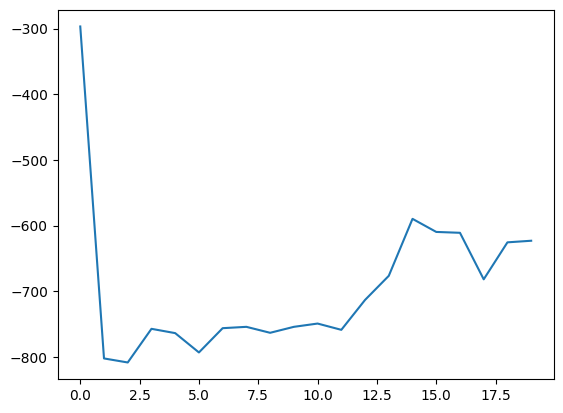

In [95]:
import matplotlib.pyplot as plt
plt.plot(rewards)

Łączny reward: -660.95 | Liczba kroków: 316


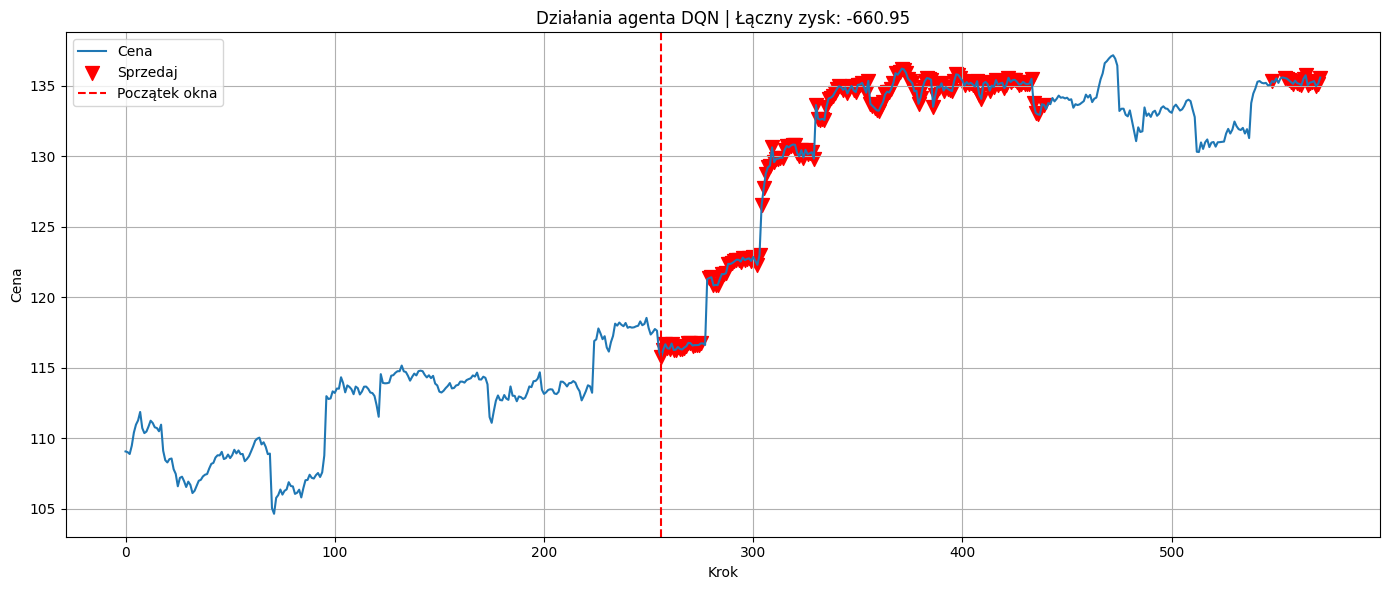

-660.9499999999994

In [96]:
test_dqn_agent(valid_env, agent)

Łączny reward: 8720.66 | Liczba kroków: 2028


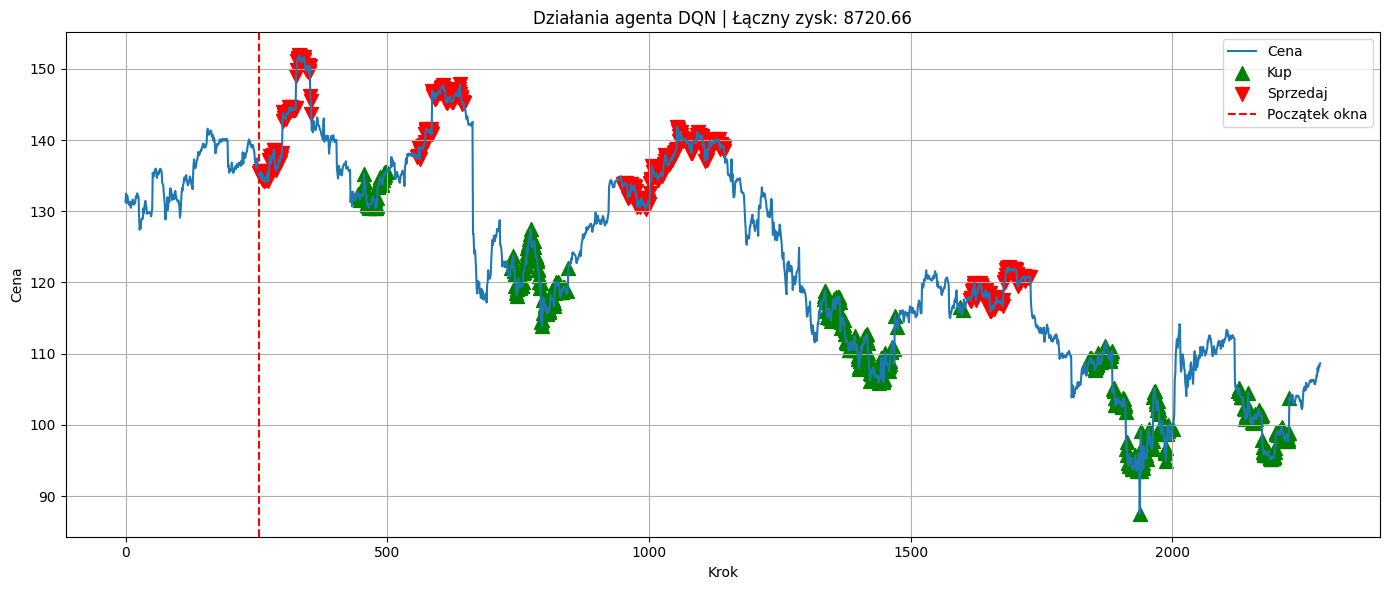

8720.660000000002

In [97]:
test_dqn_agent(env, agent)